<a href="https://colab.research.google.com/github/alice202122/AI_PROJECT/blob/main/AI_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CONNECTING TO DRIVE

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
%cd /gdrive/MyDrive/AI_Assignment/training_set

In [ ]:
!unzip training_set.zip

# IMPORTING LIBRARIES

In [ ]:
from scipy.io import loadmat

import numpy as np, os
from numpy import array, matrix, multiply, arange, absolute

from scipy import signal
from scipy.signal import lfilter, medfilt, resample, kaiserord, firwin, freqz, correlate

import pandas as pd

import ntpath

import matplotlib.pyplot as plt
from matplotlib import pylab as plt
 
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show, legend, axis

import copy

!pip install pyhrv
import pyhrv
import pyhrv.time_domain as td

!pip install biosppy
import biosppy
from biosppy.signals import ecg, tools

import math
from math import pi

#DATA LOADING

In [4]:
input_directory = '/gdrive/MyDrive/AI_Assignment/training_set'

We want to adjust the dataset in a matrix to better organize the available data. The matrix structure is the following:

    | ECG (I & II lead) | R peaks location (samples) | Beats annotation ('N', 'S', 'V') |


In [5]:
def storage(empty_list, input_directory, last_character, name):

  for file in sorted(os.listdir(input_directory)):       # search amongst files in input directory
    filename = ntpath.basename(file)                     # get file name
    filename = os.path.splitext(filename)[0]             # remove file extension
    if filename.endswith(last_character):                # check filename last character
      mat_file = filename + '.mat'                       # rejoin extension to filename
      x = loadmat(mat_file)                              # load file
      values = np.asarray(x[name])                       # load values
      empty_list.append(values)                          # store values in a list

  num_files = len(empty_list)                            # checking all files have been stored

  return empty_list, num_files

###ECGs

In [6]:
ECGs = []         # list initialization
ECGs, num_files = storage(ECGs, input_directory, ('8','0'), 'ecg')
num_files

105

###R PEAKS LOCATION 

In [7]:
Rpks = []          # list initialization
Rpks, num_files = storage(Rpks, input_directory, 'k', 'rpeaks')
num_files

105

###BEATS ANNOTATIONS

In [8]:
beats_anns = []    # list initialization
beats_anns, num_files = storage(beats_anns, input_directory, 'n', 'labels')
num_files

105

###FINAL MATRIX

In [9]:
data = []                                                                         # list initialization
row = []                                                                          # list initialization
for patient in range(num_files):                                                  # scrolls patient by patient
  row = [ ECGs[patient], Rpks[patient], beats_anns[patient] ]  
  data.append(row)                                                                # store row in a list

#DATA INSPECTION

###SIGNALS LENGTH DISTRIBUTION

In [10]:
def signals_lenght_distr(input_directory, last_character, fs):       

  ECGs_fs = []
  ECGs, num_files = storage(ECGs_fs, input_directory, last_character, 'ecg') 

  ECG = 0                                                    
  ECGsfs_lengths = []                                   # list initialization
  for patient in range(len(ECGs_fs)):                   # scrolls patient by patient
    ECGsfs_lengths.append(len(data[patient][ECG])/fs)   # store signals length in a list

  ECGsfs_lengths = pd.Series(ECGsfs_lengths)
  ax = ECGsfs_lengths.plot.hist(bins=12, alpha=0.5)
  ax.set_title("Signals length distribution (fs = " + str(fs) + " Hz)")

  return ECGs_fs, num_files

####128 Hz signals

65

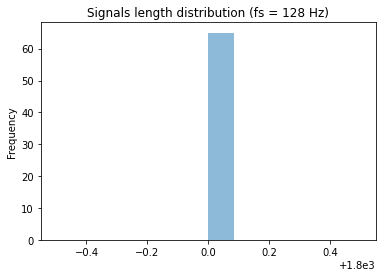

In [11]:
ECGs_128, num_files = signals_lenght_distr(input_directory, '8', 128)
num_files   # checking all files have been stored

####250 Hz signals

40

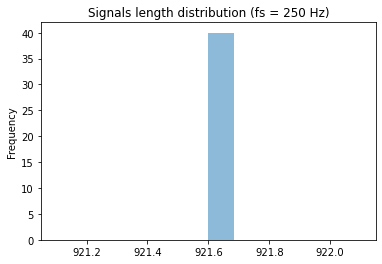

In [12]:
ECGs_250, num_files = signals_lenght_distr(input_directory, '0', 250)
num_files   # checking all files have been stored

###OTHERS

#PRE-PROCESSING

###UPSAMPLING

Upsampling is the process of inserting zero-valued samples between the original samples of a signal to increase the sampling rate. We want, indeed, to bring all the signals at the same sampling frequency of 250 Hz. Downsampling to the 128 Hz is not recommendable otherwise we would lose informations.

In [13]:
def upsampling(ECG_old, fs_old, fs_up):

  deltafs_old = 1/fs_old                                                          # old sampling interval (s)
  duration_old = int(deltafs_old*len(ECG_old))                                    # signal duration (s)
  samples_old = duration_old*fs_old                                               # number of samples with old sampling frequency
  timevec_old = np.linspace(0, duration_old, samples_old, False)                  # old time vector

  deltafs_up = 1/fs_up                                                            # new sampling interval (s)
  samples_up = duration_old*fs_up                                                 # number of samples expected with new sampling frequency
  timevec_up = np.linspace(0, duration_old, samples_up, False)                    # new time vector

  ECG_up = signal.resample(ECG_old, samples_up)                                   # ECG upsampled

  return timevec_old, timevec_up, ECG_up

####Example for one signal

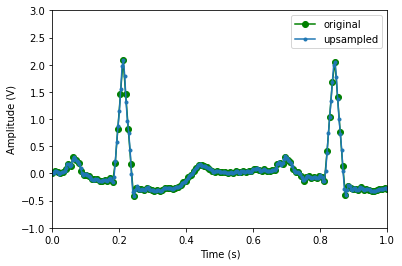

In [14]:
patient = 0
ECG = 0
Ilead = 0
ECG_128 = data[patient][ECG][:,Ilead]        # ECG I lead from patient S001_128

time_128, time_250, ECG128_up = upsampling(ECG_128, 128, 250)

plt.plot(time_128, ECG_128, 'go-', time_250, ECG128_up, '.-')
plt.axis([0, 1, -1, 3])                                         
plt.legend(['original', 'upsampled'], loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.show()

####For all 128 Hz signals

In [15]:
ECGs128_up = []                                      # list initialization
ECG = 0
for patient in range(len(ECGs_128)):                 # scrolls patient by patient
  ECG_128 = data[patient][ECG]                       # both ECG leads
  ECG128_up = upsampling(ECG_128, 128, 250)[2]       # ECG upsampled
  ECGs128_up.append(ECG128_up)                       # store ECGs upsampled in a list

In [16]:
ECGs_up = ECGs128_up                      # new array of upsampled ECGs
for patient in range(len(ECGs_250)):      # scroll patient by patient
  ECGs_up.append(ECGs_250[patient])       # append the ECGs at 250 Hz
num_files = len(ECGs_up)                             
num_files                                 # checking all files have been stored        

105

In [17]:
data_up = []                                                                     # list initialization
row = []                                                                         # list initialization
for patient in range(num_files):                                                 # scrolls patient by patient
  row = [ ECGs_up[patient], Rpks[patient], beats_anns[patient] ]                 # store ECG upsampled, R peaks location, beats annotation for each patient in a row
  data_up.append(row)                                                            # store row in a list

###BASELINE DETECTION

We want to detect the baseline and remove it from the overall signals because not necessary to the features of interest when computing the power spectrum. Indeed, the baseline wander mainly corresponds to the movement and respiration of the patient.

####Example for one signal

Text(0, 0.5, 'Amplitude (V)')

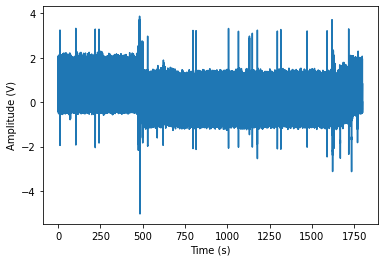

In [18]:
patient = 0
ECG = 0
Ilead = 0
ECG = data_up[patient][ECG][:,Ilead]       # ECG I lead from patient S001_128 (S001_250)

fs = 250                                                          # sampling frequency (Hz)
delta_fs = 1/fs                                                   # sampling interval (s)
duration = int(delta_fs*len(ECG))                                 # signal duration (s)
samples = duration*fs                                             # number of samples
time_vec = np.linspace(0, duration, samples, endpoint=False)      # time vector

plot(time_vec, ECG)
xlabel('Time (s)')
ylabel('Amplitude (V)')

In [19]:
def power_spectrum(data, sampling_rate):
  fourier_transform = np.fft.rfft(data)                                 # FFT computation
  abs_fourier_transform = np.abs(fourier_transform)                     # FFT absolute value
  power_spectrum = np.square(abs_fourier_transform)                     # power spectrum
  frequency = np.linspace(0, sampling_rate/2, len(power_spectrum))      # vector of frequencies

  return frequency, power_spectrum

Text(0, 0.5, 'Power Spectrum (dB/Hz)')

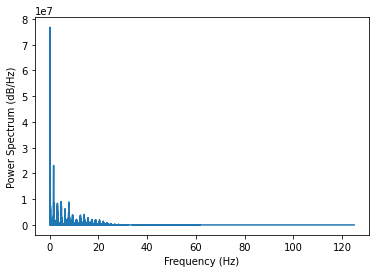

In [20]:
ECG_f, ECG_ps = power_spectrum(ECG, fs)
plt.plot(ECG_f, ECG_ps)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectrum (dB/Hz)')

Plotting the signal in the frequency domain we are able to detect the baseline contribution as the highest peak.

######Median Filter (200 ms)

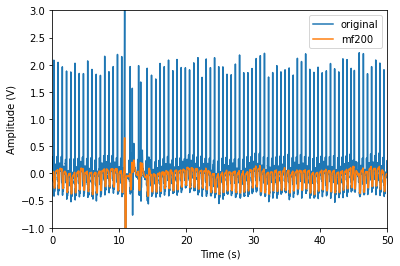

In [21]:
ECG_mf200 = signal.medfilt(ECG, 51)    # kernel_size = 200ms*250Hz = 50 samples (+1 the one being filtered)
plt.plot(time_vec, ECG, time_vec, ECG_mf200)
plt.axis([0, 50, -1, 3])
plt.legend(['original', 'mf200'], loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.show()

######Median Filter (600 ms)

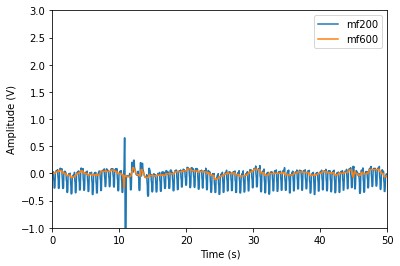

In [22]:
ECG_mf600 = signal.medfilt(ECG_mf200, 151)    # kernel_size = 600ms*250Hz = 150 samples (+1 the one being filtered)
plt.plot(time_vec, ECG_mf200, time_vec, ECG_mf600)
plt.axis([0, 50, -1, 3])
plt.legend(['mf200', 'mf600'], loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.show()

######Baseline Removal

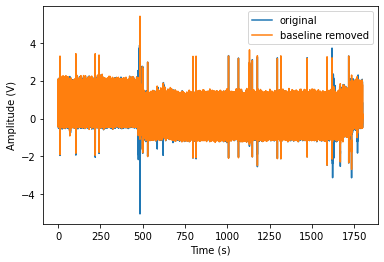

In [23]:
ECG_blr = ECG-ECG_mf600
plt.plot(time_vec, ECG, time_vec, ECG_blr)
plt.legend(['original', 'baseline removed'], loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.show()

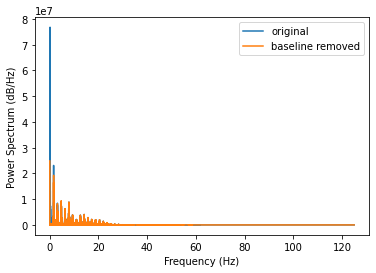

In [24]:
ECGblr_f, ECGblr_ps = power_spectrum(ECG_blr, fs)
plt.plot(ECG_f, ECG_ps, ECGblr_f, ECGblr_ps)
plt.legend(['original', 'baseline removed'], loc='best')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectrum (dB/Hz)')
plt.show()

As we can see the baseline component has been removed.

####For all signals

In [25]:
ECGsup_blr = []
ECG = 0
Ilead = 0
IIlead = 1
for patient in range(num_files):                      # scrolls patient by patient
  ECGI_up = data_up[patient][ECG][:,Ilead]            
  ECGIup_mf200 = signal.medfilt(ECGI_up, 51)          # kernel_size = 200ms*250Hz = 50 samples (+1 the one being filtered)
  ECGIup_mf600 = signal.medfilt(ECGIup_mf200, 151)    # kernel_size = 600ms*250Hz = 150 samples (+1 the one being filtered)
  ECGIup_blr = ECGI_up-ECGIup_mf600                   # baseline removal
  ECGII_up = data_up[patient][ECG][:,IIlead]            
  ECGIIup_mf200 = signal.medfilt(ECGII_up, 51)          # kernel_size = 200ms*250Hz = 50 samples (+1 the one being filtered)
  ECGIIup_mf600 = signal.medfilt(ECGIIup_mf200, 151)    # kernel_size = 600ms*250Hz = 150 samples (+1 the one being filtered)
  ECGIIup_blr = ECGII_up-ECGIIup_mf600                  # baseline removal
  ECGup_blr = [ECGIup_blr, ECGIIup_blr]
  ECGsup_blr.append(ECGup_blr)

In [26]:
dataup_blr = []                                                                  # list initialization
row = []                                                                         # list initialization
for patient in range(num_files):                                                 # scrolls patient by patient
  row = [ ECGsup_blr[patient], Rpks[patient], beats_anns[patient] ]              # store ECG baseline removed, R peaks location, beats annotation for each patient in a row
  dataup_blr.append(row)                                                         # store row in a list

###FILTERING

####Example for one signal

Text(0, 0.5, 'Amplitude (V)')

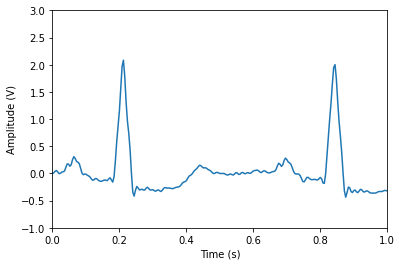

In [27]:
patient = 0
ECG = 0
Ilead = 0
ECG = dataup_blr[patient][ECG][Ilead]       # ECG I lead from patient S001_128 (S001_250)

fs = 250                                                          # sampling frequency (Hz)
delta_fs = 1/fs                                                   # sampling interval (s)
duration = int(delta_fs*len(ECG))                                 # signal duration (s)
samples = duration*fs                                             # number of samples
time_vec = np.linspace(0, duration, samples, endpoint=False)      # time vector

plot(time_vec, ECG)
plt.axis([0, 1, -1, 3])
xlabel('Time (s)')
ylabel('Amplitude (V)')

From this plot it can be noticed that the ECG signal needs to be smoothed out. For this reason, we apply a low pass filter to get rid of the high frequencies responsible of those ripples.

In [28]:
def FIRlowpass(sample_rate, signal, time_axis, cutoff_hz, start, end, figs):

  nyq_rate = sample_rate / 2.0
  width = 5.0/nyq_rate # the desired width of the transition from pass to stop,
                       # relative to the Nyquist rate.  We'll design the filter
                       # with a 5 Hz transition width.
  ripple_db = 60.0     # the desired attenuation in the stop band, in dB
  N, beta = kaiserord(ripple_db, width) # compute the order and Kaiser parameter for the FIR filter.
  taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))
  filtered = lfilter(taps, 1.0, signal)

  if figs == True:

    figure(1) # filter coefficients
    plot(taps, 'bo-', linewidth=2)
    title('Filter Coefficients (%d taps)' % N)
    grid(True)

    figure(2) # filter magnitude response
    clf()
    w, h = freqz(taps, worN=8000)
    plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
    xlabel('Frequency (Hz)')
    ylabel('Gain')
    title('Frequency Response')
    ylim(-0.05, 1.05)
    grid(True)
    ax1 = axes([0.42, 0.6, .45, .25]) # upper inset plot
    plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
    xlim(0,8.0)
    ylim(0.9985, 1.001)
    grid(True)
    ax2 = axes([0.42, 0.25, .45, .25]) # lower inset plot
    plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
    xlim(60.0, 80.0)
    ylim(-0.05, 0.05)
    grid(True)

    delay = 0.5 * (N-1) / sample_rate # the phase delay of the filtered signal
    figure(3) # original vs filtered signal
    axis([start, end, -1, 3])
    plot(time_axis, signal)
    #plot(time_axis-delay, filtered_x, 'r-')
    plot(time_axis[N-1:]-delay, filtered[N-1:], 'r', linewidth=1) # plot just the "good" part of the filtered signal. The first N-1
                                                                    # samples are "corrupted" by the initial conditions.
    legend(['original', 'filtered'], loc='best')
    xlabel('Time (s)')
    ylabel('Amplitude (V)')
    grid(True)

    figure(4)
    signal_f, signal_ps = power_spectrum(signal, fs)
    filt_f, filt_ps = power_spectrum(filtered, fs)
    plot(signal_f, signal_ps, filt_f, filt_ps)
    legend(['original', 'filtered'], loc='best')
    xlabel('Frequency (Hz)')
    ylabel('Power Spectrum (dB/Hz)')

    show()
    
  elif figs == False:
    plt.close('all')

  return filtered

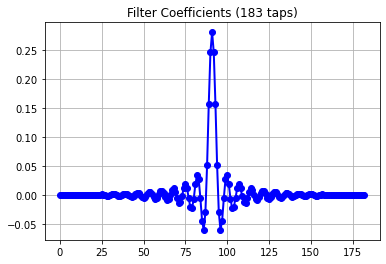

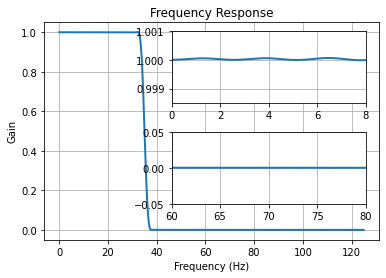

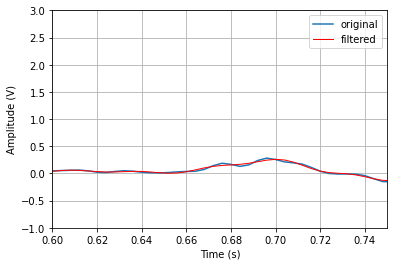

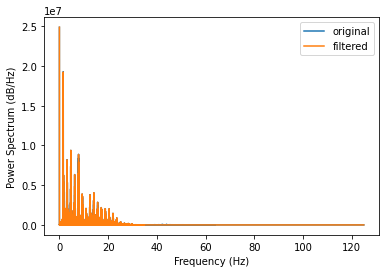

In [29]:
ECG_filt = FIRlowpass(fs, ECG, time_vec, 35, 0.60, 0.75, True)

####For all signals

In [30]:
ECGsupblr_filt = []
ECG = 0
Ilead = 0
IIlead = 1
for patient in range(num_files):                                                 # scrolls patient by patient
  ECGIup_blr = dataup_blr[patient][ECG][Ilead]            
  ECGIupblr_filt = FIRlowpass(fs, ECGIup_blr, time_vec, 35, [], [], False)         
  ECGIIup_blr = dataup_blr[patient][ECG][IIlead]            
  ECGIIupblr_filt = FIRlowpass(fs, ECGIIup_blr, time_vec, 35, [], [], False)
  ECGupblr_filt = [ECGIupblr_filt, ECGIIupblr_filt]
  ECGsupblr_filt.append(ECGupblr_filt)

In [31]:
dataupblr_filt = []                                                              # list initialization
row = []                                                                         # list initialization
for patient in range(num_files):                                                 # scrolls patient by patient
  row = [ ECGsupblr_filt[patient], Rpks[patient], beats_anns[patient] ]          # store ECG filtered, R peaks location, beats annotation for each patient in a row
  dataupblr_filt.append(row)                                                     # store row in a list

#FEATURE EXTRACTION

###HRV FEATURES

Two different time windows are considered for the extraction of HRV features: 3 and 10 min windows centered on the current beats.

In [39]:
wnw_3 = 180             # time window duration in s
wnw3_smp = wnw_3*fs     # number of samples in the window

Rpks_tr3 = []
Rpks = 1
for patient in enumerate(dataupblr_filt[patient][Rpks]):
  temp = []
  for idx, k in enumerate(dataupblr_filt[patient][Rpks]):
    if (k-int(wnw3_smp/2))>0:
      temp.append(k)
  temp = np.vstack(temp)
  lst = copy.deepcopy(temp)
  Rpks_tr3.insert(idx, lst)
  Rpks_tr3 = np.vstack(Rpks_tr3)

TypeError: ignored

In [38]:
Rpks_tr3[0]

array([22511], dtype=int32)

In [ ]:
wnw_10 = 600             # time window duration in s
wnw10_smp = wnw_10*fs    # number of samples in the window

Rpks_tr10 = []
Rpks = 1
for patient in range(num_files):
  Rpks = dataupblr_filt[patient][Rpks]
  for idx, k in enumerate(Rpks):
    if (k-wnw10_smp)>0:
      Rpks_tr10.append(k)
Rpks_tr10 = np.vstack(Rpks_tr10)

In [ ]:
rpks = data_up[0][2]
rpks_tr = []
for idx, k in enumerate(rpks[0:(len(rpks)-40)]):
  if (k-wnw1_smp)>0:
    rpks_tr.append(k)
rpks_tr = np.vstack(rpks_tr)

In [ ]:
# 1 min windows preceding the current beat
temp = []
rpks_wnw = []
for idx, i in enumerate(rpks_tr):
  temp = []
  for idx, k in enumerate(rpks):
    if k>(i-wnw1_smp) and k<i:
      temp.append(k)
  temp = np.vstack(temp)
  lst = copy.deepcopy(temp)
  rpks_wnw.insert(idx, lst)

rpkswnw_t = []
for idx, i in enumerate(rpks_wnw):
  temp = []
  for idx, k in enumerate(i[:-1]):
    pdt = k*deltafs_250
    temp.append(pdt)
  temp = np.vstack(temp)
  lst = copy.deepcopy(temp)
  rpkswnw_t.insert(idx, lst)

HRV_wnw1 = []
row = []
count = 0
for idx, i in enumerate(rpkswnw_t):
  RRs = [j-i for i, j in zip(np.array(i[:-1]), np.array(i[1:]))]
  RRs = np.vstack(RRs)
  RRs_mean = np.mean(RRs)
  RRs_std = np.std(RRs)
  RMSSD = pyhrv.time_domain.rmssd(RRs, rpks*deltafs_250) 
  dRRs = [j-i for i, j in zip(np.array(RRs[:-1]), np.array(RRs[1:]))]
  dRRs = np.vstack(dRRs)
  dRRs_mean = np.mean(dRRs)
  dRRs_std = np.std(dRRs)
  pNN10 = sum([i>0.01 for i in dRRs])*100/len(dRRs)
  pNN20 = sum([i>0.02 for i in dRRs])*100/len(dRRs)
  pNN30 = sum([i>0.03 for i in dRRs])*100/len(dRRs)
  pNN40 = sum([i>0.04 for i in dRRs])*100/len(dRRs)
  pNN50 = sum([i>0.05 for i in dRRs])*100/len(dRRs)
  row = [ rpks_tr[count], round(RRs_mean, 2) , round(RRs_std, 3), round(RMSSD[0], 2), round(dRRs_mean, 5), round(dRRs_std, 4), np.round(pNN10, 2), np.round(pNN20, 2), np.round(pNN30, 2), np.round(pNN40, 2), np.round(pNN50, 2)]
  HRV_wnw1.append(row)
  count = count+1
HRVwnw1_df = pd.DataFrame(HRV_wnw1, columns =['R peak Loc', 'RRs_mean', 'RRs_std', 'RMSSD', 'dRRs_mean', 'dRRs_std', 'pNN10', 'pNN20', 'pNN30', 'pNN40', 'pNN50'])
HRVwnw1_df

,R peak Loc,RRs_mean,RRs_std,RMSSD,dRRs_mean,dRRs_std,pNN10,pNN20,pNN30,pNN40,pNN50
0,[15100],0.39,0.047,83.82,0.00048,0.0838,[50.0],[50.0],[50.0],[50.0],[50.0]
1,[15191],0.39,0.047,83.81,-0.00051,0.0838,[49.33],[49.33],[49.33],[49.33],[49.33]
2,[15301],0.39,0.047,83.74,0.00053,0.0837,[50.0],[50.0],[50.0],[50.0],[50.0]
3,[15390],0.39,0.047,83.69,-0.00043,0.0837,[49.33],[49.33],[49.33],[49.33],[49.33]
4,[15497],0.39,0.047,83.70,0.00056,0.0837,[50.0],[50.0],[50.0],[50.0],[50.0]
...,...,...,...,...,...,...,...,...,...,...,...
2136,[226303],0.40,0.032,63.62,0.00051,0.0635,[50.0],[50.0],[50.0],[50.0],[45.95]
2137,[226396],0.40,0.032,63.74,-0.00051,0.0636,[49.32],[49.32],[49.32],[49.32],[45.27]
2138,[226487],0.40,0.032,63.82,0.00043,0.0637,[50.0],[50.0],[50.0],[50.0],[45.95]
2139,[226577],0.40,0.032,63.89,-0.00041,0.0638,[49.32],[49.32],[49.32],[49.32],[45.27]


###MORPHOLOGICAL FEATURES

In [ ]:
#Example for only one signal
rpks = data_up[0][2]
rpks_tr = []
for idx, k in enumerate(rpks[1:(len(rpks)-40)]):
  rpks_tr.append(k)
rpks_tr = np.vstack(rpks_tr)

In [ ]:
def extractor(wnwst_smp, wnwend_smp):
  wnwst_smp = round(wnwst_t*fs_250)
  wnwend_smp = round(wnwend_t*fs_250)
  extractions = []
  count = 0
  for idx, i in enumerate(rpks_tr): 
    rpk_t = i*deltafs_250
    wnw = range(int(i)-wnwst_smp, int(i)+wnwend_smp)
    time = np.linspace((rpk_t-wnwst_t), (rpk_t+wnwend_t), len(ECGblr_filt[wnw]), endpoint=True)
    row = [ i, time, ECGblr_filt[wnw] ]
    extractions.append(row)
    count = count+1
  return extractions

####Whole Beat

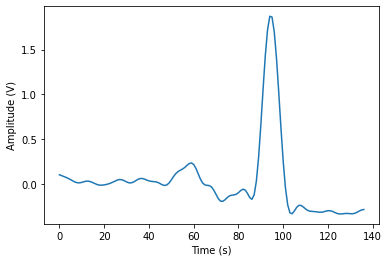

In [ ]:
wnwst_t = 0.3 
wnwend_t = 0.25
beats = extractor(wnwst_t, wnwend_t)
n_beat = 3
plot(beats[n_beat][2])
xlabel('Time (s)')
ylabel('Amplitude (V)')
show()

####P wave

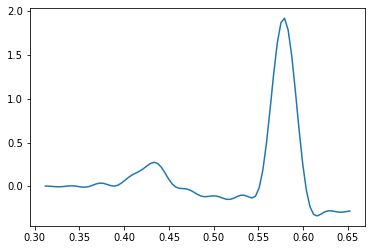

In [ ]:
wnwst_t = 0.3 
wnwend_t = 0.04
wnwst_smp = round(wnwst_t*fs_250)
wnwend_smp = round(wnwend_t*fs_250)
Pwaves = extractor(wnwst_smp, wnwend_smp)
plot(Pwaves[0][1], Pwaves[0][2])
show()

####QRS complex

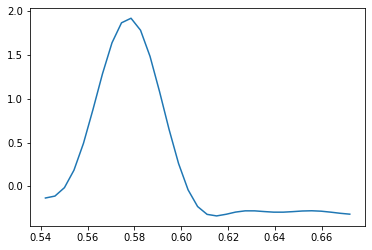

In [ ]:
wnwst_t = 0.07 
wnwend_t = 0.06
wnwst_smp = round(wnwst_t*fs_250)
wnwend_smp = round(wnwend_t*fs_250)
QRSs = extractor(wnwst_smp, wnwend_smp)
plot(QRSs[0][1], QRSs[0][2])
show()

####PR interval

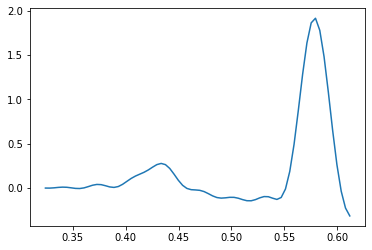

In [ ]:
wnwst_t = 0.288 
wnwend_t = 0
wnwst_smp = round(wnwst_t*fs_250)
wnwend_smp = round(wnwend_t*fs_250)
PRs = extractor(wnwst_smp, wnwend_smp)
plot(PRs[0][1], PRs[0][2])
show()

In [ ]:
def template(n_prior, n_post):
  tplt = []
  count = 0
  for idx, i in enumerate(beats):
    if idx>n_prior and idx<(len(beats)-n_post):
      row = [ beats[idx][0], beats[(idx-n_prior):(idx+n_post)]]
      tplt.append(row)
  return tplt

In [ ]:
tplt_80 = template(40,40)
tplt_20 = template(10,10)
tplt_4 = template(2,2)

-57.0

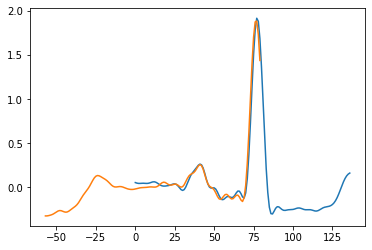

In [ ]:
n_beat1 = 42
n_beat2 = 1
plt.plot(beats[n_beat1][2])
for target in [beats[n_beat2]]:
    time = np.arange(0, 137, 1)
    dx = np.mean(np.diff(time))
    shift = (np.argmax(signal.correlate(beats[n_beat1][2], target[2])) - len(target[2])) * dx
    plt.plot(time+shift, target[2])
shift

In [ ]:
count = 0
nbeat_smp = []
temp = []
lst1 = []
lst2 = []
row = []
corr_80 = []
for nbeat_smp, beats80 in tplt_80:
  for nbeatsmp, t, ecg in beats:
    while (nbeat_smp != beats[count][0]):
      count = count+1
  beat_ecg = beats[count][2]
  nbeat_smp = []
  temp = []
  for k in range(len(tplt_80[0][1])):
    max = (np.argmax(signal.correlate(beat_ecg, tplt_80[0][1][k][2])) - len(tplt_80[0][1][k][2]))
    nbeat_smp.append(tplt_80[0][1][k][0])
    temp.append(max)
  nbeat_smp = np.vstack(nbeat_smp)
  temp = np.vstack(temp)
  lst1 = copy.deepcopy(nbeat_smp)
  lst2 = copy.deepcopy(temp)
  row = [ beats[count][0], lst1, lst2 ]
  corr_80.append(row)

In [ ]:
corr_80[0]

[array([4156], dtype=int32), array([[ 243],
        [ 352],
        [ 440],
        [ 547],
        [ 636],
        [ 742],
        [ 831],
        [ 937],
        [1028],
        [1136],
        [1225],
        [1331],
        [1420],
        [1525],
        [1614],
        [1721],
        [1811],
        [1919],
        [2008],
        [2115],
        [2203],
        [2309],
        [2398],
        [2504],
        [2594],
        [2702],
        [2790],
        [2897],
        [2985],
        [3090],
        [3179],
        [3285],
        [3374],
        [3482],
        [3571],
        [3677],
        [3765],
        [3871],
        [3960],
        [4065],
        [4156],
        [4264],
        [4352],
        [4457],
        [4546],
        [4652],
        [4742],
        [4848],
        [4938],
        [4942],
        [5046],
        [5135],
        [5242],
        [5331],
        [5437],
        [5528],
        [5635],
        [5725],
        [5834],
        [5925],
        [603

In [ ]:
corr_80[0][1]

In [ ]:
import pandas as pd
from scipy import stats

df=pd.DataFrame({'nbeat_smp':np.ndarray.tolist(corr_80[0][1]), 'max_corr':np.ndarray.tolist(corr_80[0][2])})
df['z_score']=stats.zscore(np.ndarray.tolist(corr_80[0][2]))

In [ ]:
df_out = df.loc[df['z_score'].abs()<=0.5]
df_out

,nbeat_smp,max_corr,z_score
4,[636],[-29],0.169303
7,[937],[-44],-0.170435
12,[1420],[-36],0.010758
15,[1721],[-52],-0.351628
20,[2203],[-46],-0.215733
25,[2702],[-23],0.305198
26,[2790],[-45],-0.193084
28,[2985],[-55],-0.419576
29,[3090],[-30],0.146653
38,[3960],[-37],-0.011891


In [ ]:
ecgtmp_80 = []
for i in df_out['nbeat_smp']:
  for k in range(len(tplt_80[0][1])):
    if i[0] == tplt_80[0][1][k][0]:
      ecgtmp_80.append(tplt_80[0][1][k][2])  

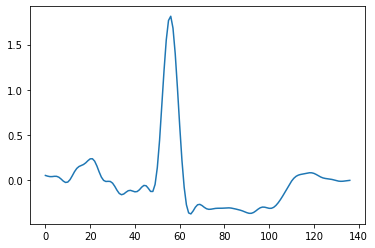

In [ ]:
plot(ecgtmp_80[0])

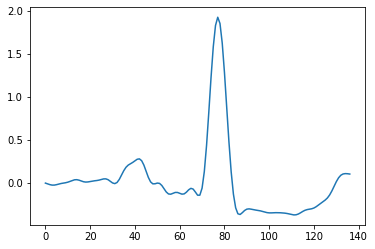

In [ ]:
plot(ecgtmp_80[21])

In [ ]:
sum = 0
for i in ecgtmp_80:
  sum = sum+np.array([i])

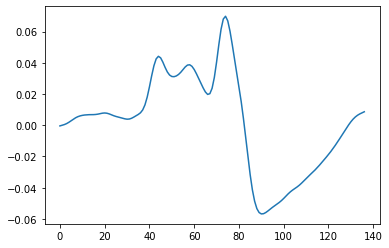

In [ ]:
ecg_mean80 = np.vstack(sum[0])/len(np.vstack(sum[0]))
plot(ecg_mean80)

In [ ]:
beats[41][0]

In [ ]:
ecg_mean80

In [ ]:
beat_ecg

In [ ]:
from scipy import signal
beat_ecg = beats[41][2]
max = (np.argmax(signal.correlate(np.vstack(beat_ecg), ecg_mean80)) - len(ecg_mean80))
time = np.arange(0, 137, 1)
dx = np.mean(np.diff(time))
lag = max * dx
md_std = stats.median_absolute_deviation(ecgtmp_80)